In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch

import flowviz
import flow_transforms

%matplotlib inline

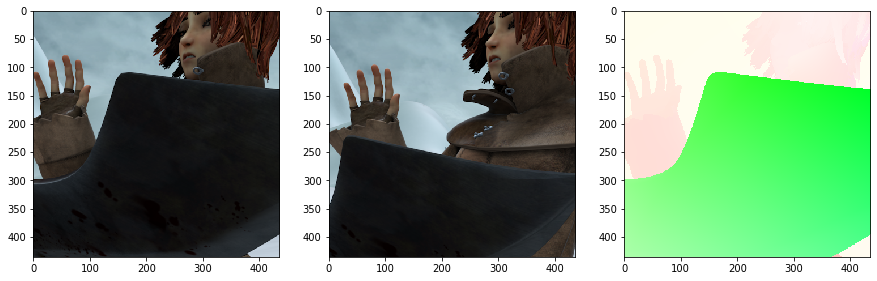

In [2]:
img1 = cv2.cvtColor(cv2.imread('mpi_sintel_data/frame_0014.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('mpi_sintel_data/frame_0015.png'), cv2.COLOR_BGR2RGB)
flow = flowviz.read_flow('mpi_sintel_data/frame_0014.flo')

# Crop the center square region
img1 = img1[:, 294:-294]
img2 = img2[:, 294:-294]
flow = flow[:, 294:-294]

flow_img = flowviz.convert_from_flow(flow)

fig = plt.figure(figsize=(15, 5))
fig.add_subplot(1, 3, 1)
plt.imshow(img1)
fig.add_subplot(1, 3, 2)
plt.imshow(img2)
fig.add_subplot(1, 3, 3)
plt.imshow(flow_img)
plt.show()

In [8]:
images_t, flows_t = flow_transforms.ToTensor()([img1, img2], [flow])
print(images_t.shape, flows_t.shape)

torch.Size([2, 3, 436, 436]) torch.Size([1, 2, 436, 436])


In [9]:
transforms_list = [
    flow_transforms.RandomHorizontalFlip(),
    flow_transforms.RandomVerticalFlip(),
    flow_transforms.AddGaussianNoise(stdev=30),
    flow_transforms.RandomAdditiveColor(stdev=50, independent=True),
    flow_transforms.RandomMultiplicativeColor(range_min=0.5, range_max=2, independent=True),
    flow_transforms.RandomGammaColor(range_min=0.5, range_max=2, pixel_min=0, pixel_max=255, independent=True),
    flow_transforms.RandomCrop(size=(300, 300)),
    flow_transforms.RandomRotate(angle=90, diff_angle=30),
    flow_transforms.RandomScale(range_min=0.5, range_max=2),
    flow_transforms.RandomTranslate(translation=(50, 50)),
]

In [10]:
results = []
for t in transforms_list:
    results.append(t(images_t.clone(), flows_t.clone()))

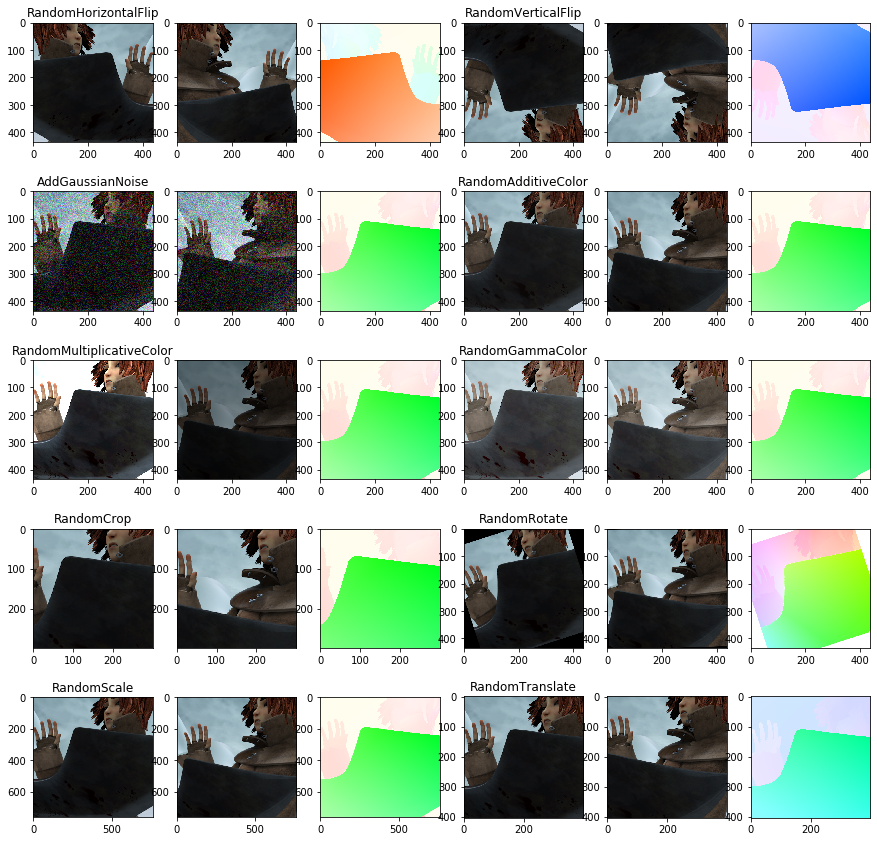

In [11]:
fig = plt.figure(figsize=(15, 15))
rows = len(results)//2
cols = 6
for i, res in enumerate(results):
    img_t, flow_t = res
    img = img_t.numpy().transpose(0, 2, 3, 1)
    img = np.maximum(0, np.minimum(255, img))
    img = img.astype(np.uint8)
    fig.add_subplot(rows, cols, 3*i+1).set_title(transforms_list[i].__class__.__name__)
    plt.imshow(img[0])
    fig.add_subplot(rows, cols, 3*i+2)
    plt.imshow(img[1])
    flow_res = flow_t[0].numpy().transpose(1, 2, 0)
    flow_img = flowviz.convert_from_flow(flow_res)
    fig.add_subplot(rows, cols, 3*i+3)
    plt.imshow(flow_img)
plt.show()
    

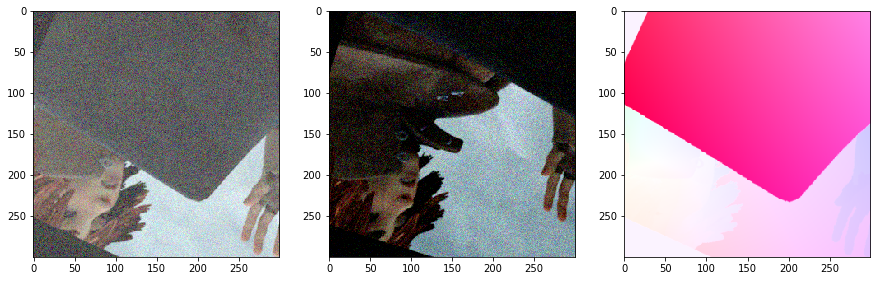

In [12]:
# Composing multiple transforms
transform = flow_transforms.Compose([
    flow_transforms.ToTensor(),
    flow_transforms.RandomRotate(angle=45, diff_angle=15),
    flow_transforms.RandomTranslate(translation=(15, 15)),
    flow_transforms.RandomScale(range_min=0.9, range_max=2),
    flow_transforms.RandomCrop(size=(300, 300)),
    flow_transforms.RandomHorizontalFlip(),
    flow_transforms.RandomVerticalFlip(),
    flow_transforms.AddGaussianNoise(stdev=20),
    flow_transforms.RandomAdditiveColor(stdev=20, independent=True),
    flow_transforms.RandomMultiplicativeColor(range_min=0.9, range_max=1.1, independent=True),
    flow_transforms.RandomGammaColor(range_min=0.75, range_max=1.5, pixel_min=0, pixel_max=255, independent=True),
])
images_t, flows_t = transform([img1, img2], [flow])
fig = plt.figure(figsize=(15, 5))
img = images_t.numpy().transpose(0, 2, 3, 1)
img = np.maximum(0, np.minimum(255, img))
img = img.astype(np.uint8)
fig.add_subplot(1, 3, 1)
plt.imshow(img[0])
fig.add_subplot(1, 3, 2)
plt.imshow(img[1])
flow_res = flows_t[0].numpy().transpose(1, 2, 0)
flow_img = flowviz.convert_from_flow(flow_res)
fig.add_subplot(1, 3, 3)
plt.imshow(flow_img)
plt.show()